# Final Project Report

* Class: DS 5100
* Student Name: Daniel Ra
* Student Net ID: wr9cn
* This URL: https://github.com/D-W-Ra/Final-Project-DS5100/blob/main/DS51200_FinalProjectTemplate.ipynb

# Instructions

Follow the instructions in the Final Project isntructions notebook and put evidence of your work in this notebook.

Total points for each subsection under **Deliverables** and **Scenarios** are given in parentheses.

Breakdowns of points within subsections are specified within subsection instructions as bulleted lists.

This project is worth **50 points**.

# Deliverables

## The Monte Carlo Module (10)

- URL included, appropriately named (1).
- Includes all three specified classes (3).
- Includes at least all 12 specified methods (6; .5 each).

Put the URL to your GitHub repo here.

Repo URL: https://github.com/D-W-Ra/Final-Project-DS5100#

Paste a copyy of your module here.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

```
import numpy as np
import pandas as pd

class Die:
    """
    A die has N sides or faces
    Faces can be strings or numbers
    Weights default to 1.0 but can be changed after initialization
    
    Attributes:
        _die (DataFrame): Private dataframe with faces and weights
    """
    
    def __init__(self, faces):
        """
        Initialize a die with faces and default weights of 1.0

        Args:
            faces (numpy.ndarray): Array of distinct face values (numeric/strings)
        
        Raises:
            TypeError: If faces is not a numpy array
            ValueError: If faces are not distinct
        """
        if not isinstance(faces, np.ndarray):
            raise TypeError("Faces must be a NumPy array!")
        
        if len(np.unique(faces)) != len(faces):
            raise ValueError("Faces must be distinct!")
        
        self._die = pd.DataFrame({
            'face': faces,
            'weight': np.ones(len(faces))
        }).set_index('face')

    def change_weight(self, face, weight):
        """
        Change the weight of a single face.

        Args:
            face (str/number): Face value to change
            weight (float/integer): New weight (must be numeric and not negative)
        
        Raises:
            IndexError: When face is not found
            TypeError: When weight is not numeric (integer/float)
        """
        if face not in self._die.index:
            raise IndexError("Face not found in die!")
        
        try:
            weight = float(weight)
        except ValueError:
            raise TypeError("Weight must be numeric or castable to float!")
        
        self._die.at[face, 'weight'] = weight

    def roll(self, num_rolls=1):
        """
        Roll the die a given number of times.

        Args:
            num_rolls (int): Number of rolls (default 1)
        
        Returns:
            list: Outcomes of rolls
        """
        outcomes = self._die.sample(
            n=num_rolls, 
            weights=self._die['weight'], 
            replace=True
        ).index.tolist()
        return outcomes

    def show(self):
        """
        Show the die's current faces and weights

        Returns:
            pandas.DataFrame: Copy of die's faces and weights
        """
        return self._die.copy()
```

```
import pandas as pd

class Game:
    """
    A game consists of rolling one or multiple dice of the same kind multiple times
    
    Attributes:
        _dice (list): List of Die objects
        _play_results (DataFrame): Private dataframe storing the results of the most recent play
    """
    
    def __init__(self, dice):
        """
        Initialize the Game with a list of dice

        Args:
            dice (list): A list containing one or more Die objects
        """
        self._dice = dice
        self._play_results = None

    def play(self, num_rolls):
        """
        Play the game by rolling all dice a given number of times

        Args:
            num_rolls (int): Number of times to roll the dice
        Saves:
            _play_results (DataFrame): Roll results with wide format
        """
        results = {}

        for i, die in enumerate(self._dice):
            results[i] = die.roll(num_rolls)

        self._play_results = pd.DataFrame(results)
        self._play_results.index.name = 'roll_number'

    def show(self, form='wide'):
        """
        Show the results of the most recent play

        Args:
            form (str): Format of the result ('wide' or 'narrow'). Defaults to 'wide'
        Returns:
            pandas.DataFrame: Copy of the play results in the requested format
        Raises:
            ValueError: If form is not 'wide' or 'narrow'
        """
        if self._play_results is None:
            raise ValueError("No results to show; play the game first")

        if form == 'wide':
            return self._play_results.copy()
        elif form == 'narrow':
            return self._play_results.stack().to_frame('face')
        else:
            raise ValueError("Invalid form argument. Choose 'wide' or 'narrow'")
```

```
import pandas as pd
from collections import Counter
from montecarlo.game import Game

class Analyzer:
    """
    An Analyzer object takes the results of a single Game object and computes various descriptive statistical properties about it

    Attributes:
        _game (Game): Game object
        _jackpot_count (int): Number of jackpots
        _face_counts_per_roll (DataFrame): Face counts per roll
        _combo_counts (DataFrame): Distinct combinations and their counts
        _perm_counts (DataFrame): Distinct permutations and their counts
    """

    def __init__(self, game):
        """
        Initialize the Analyzer with a Game object.

        Args:
            game (Game): An instance of the Game class
        Raises:
            ValueError: If input is not a Game object
        """
        if not isinstance(game, Game):
            raise ValueError("Analyzer must be initialized with a Game object")

        self._game = game
        self._jackpot_count = None
        self._face_counts_per_roll = None
        self._combo_counts = None
        self._perm_counts = None

    def jackpot(self):
        """
        Compute the number of jackpots (all faces in a roll are identical)
        Returns:
            int: Number of jackpots
        """
        df = self._game.show('wide')
        self._jackpot_count = (df.nunique(axis=1) == 1).sum()
        return self._jackpot_count

    def face_counts_per_roll(self):
        """
        Compute how many times each face appeared in each roll

        Returns:
            pandas.DataFrame: Rows are roll numbers, columns are faces, cells are counts
        """
        df = self._game.show('wide')
        faces = pd.unique(df.values.ravel())
        counts = []

        for _, row in df.iterrows():
            row_count = Counter(row)
            counts.append([row_count.get(face, 0) for face in faces])

        self._face_counts_per_roll = pd.DataFrame(
            counts,
            columns=faces,
            index=df.index
        )
        return self._face_counts_per_roll

    def combo(self):
        """
        Compute distinct combinations of faces rolled (order-independent) and their counts

        Returns:
            pandas.DataFrame: MultiIndex of combinations, column for counts
        """
        df = self._game.show('wide')
        combos = df.apply(lambda x: tuple(sorted(x)), axis=1)

        combo_counts = combos.value_counts()
        self._combo_counts = combo_counts.to_frame('count')

        self._combo_counts.index = pd.MultiIndex.from_tuples(self._combo_counts.index)
        self._combo_counts.index.names = [f'die_{i}' for i in range(df.shape[1])]

        return self._combo_counts

    def permutation(self):
        """
        Compute distinct permutations of faces rolled (order-dependent) and their counts

        Returns:
            pandas.DataFrame: MultiIndex of permutations, column for counts
        """
        df = self._game.show('wide')
        perms = df.apply(lambda x: tuple(x), axis=1)

        perm_counts = perms.value_counts()
        self._perm_counts = perm_counts.to_frame('count')

        self._perm_counts.index = pd.MultiIndex.from_tuples(self._perm_counts.index)
        self._perm_counts.index.names = [f'die_{i}' for i in range(df.shape[1])]

        return self._perm_counts
```

## Unitest Module (2)

Paste a copy of your test module below.

NOTE: Paste as text, not as code. Use triple backticks to wrap your code blocks.

- All methods have at least one test method (1).
- Each method employs one of Unittest's Assert methods (1).

```
import unittest
import numpy as np
from montecarlo.die import Die

class TestDie(unittest.TestCase):

    def setUp(self):
        self.faces = np.array(['A', 'B', 'C'])
        self.die = Die(self.faces)

    def test_initial_weights(self):
        result = self.die.show()
        expected_weights = [1.0, 1.0, 1.0]
        self.assertListEqual(result['weight'].tolist(), expected_weights)

    def test_change_weight(self):
        self.die.change_weight('A', 2.5)
        result = self.die.show()
        self.assertEqual(result.loc['A', 'weight'], 2.5)

    def test_roll_return_type(self):
        rolls = self.die.roll(5)
        self.assertIsInstance(rolls, list)
        self.assertEqual(len(rolls), 5)

    def test_invalid_face_change_weight(self):
        with self.assertRaises(IndexError):
            self.die.change_weight('Z', 2.0)

    def test_invalid_weight_type(self):
        with self.assertRaises(TypeError):
            self.die.change_weight('A', "heavy")
```

```
import unittest
import numpy as np
import pandas as pd
from montecarlo.die import Die
from montecarlo.game import Game

class TestGame(unittest.TestCase):

    def setUp(self):
        faces = np.array(['A', 'B', 'C'])
        die1 = Die(faces)
        die2 = Die(faces)
        self.game = Game([die1, die2])

    def test_play_shape(self):
        self.game.play(10)
        result = self.game.show()
        self.assertEqual(result.shape, (10, 2))

    def test_show_wide_format(self):
        self.game.play(5)
        result = self.game.show('wide')
        self.assertIsInstance(result, pd.DataFrame)

    def test_show_narrow_format(self):
        self.game.play(5)
        result = self.game.show('narrow')
        self.assertIsInstance(result, pd.DataFrame)
        self.assertEqual(result.index.nlevels, 2)

    def test_show_invalid_format(self):
        self.game.play(5)
        with self.assertRaises(ValueError):
            self.game.show('medium')
```

```
import unittest
import numpy as np
from montecarlo.die import Die
from montecarlo.game import Game
from montecarlo.analyzer import Analyzer
import pandas as pd

class TestAnalyzer(unittest.TestCase):

    def setUp(self):
        faces = np.array(['H', 'T'])
        die1 = Die(faces)
        die2 = Die(faces)
        self.game = Game([die1, die2])
        self.game.play(10)
        self.analyzer = Analyzer(self.game)

    def test_jackpot_output(self):
        jackpots = self.analyzer.jackpot()
        self.assertTrue(isinstance(jackpots, (int, np.integer)))

    def test_face_counts_per_roll_output(self):
        face_counts = self.analyzer.face_counts_per_roll()
        self.assertIsInstance(face_counts, pd.DataFrame)
        self.assertEqual(face_counts.shape[0], 10)

    def test_combo_output(self):
        combo = self.analyzer.combo()
        self.assertIsInstance(combo, pd.DataFrame)

    def test_permutation_output(self):
        perm = self.analyzer.permutation()
        self.assertIsInstance(perm, pd.DataFrame)

    def test_invalid_analyzer_input(self):
        with self.assertRaises(ValueError):
            Analyzer("not_a_game")
```

## Unittest Results (3)

Put a copy of the results of running your tests from the command line here.

Again, paste as text using triple backticks.

- All 12 specified methods return OK (3; .25 each).

## Import (1)

Import your module here. This import should refer to the code in your package directory.

- Module successuflly imported (1).

In [54]:
import sys
sys.path.append('/home/wr9cn/Documents/MSDS/DS5100/Final-Project-DS5100')

from montecarlo.die import Die
from montecarlo.game import Game
from montecarlo.analyzer import Analyzer

## Help Docs (4)

Show your docstring documentation by applying `help()` to your imported module.

- All methods have a docstring (3; .25 each).
- All classes have a docstring (1; .33 each).

In [7]:
help(Die)
help(Game)
help(Analyzer)

Help on class Die in module montecarlo.die:

class Die(builtins.object)
 |  Die(faces)
 |  
 |  A die has N sides or faces
 |  Faces can be strings or numbers
 |  Weights default to 1.0 but can be changed after initialization
 |  
 |  Attributes:
 |      _die (DataFrame): Private dataframe with faces and weights
 |  
 |  Methods defined here:
 |  
 |  __init__(self, faces)
 |      Initialize a die with faces and default weights of 1.0
 |      
 |      Args:
 |          faces (numpy.ndarray): Array of distinct face values (numeric/strings)
 |      
 |      Raises:
 |          TypeError: If faces is not a numpy array
 |          ValueError: If faces are not distinct
 |  
 |  change_weight(self, face, weight)
 |      Change the weight of a single face.
 |      
 |      Args:
 |          face (str/number): Face value to change
 |          weight (float/integer): New weight (must be numeric and not negative)
 |      
 |      Raises:
 |          IndexError: When face is not found
 |         

## `README.md` File (3)

Provide link to the README.md file of your project's repo.

- Metadata section or info present (1).
- Synopsis section showing how each class is called (1). (All must be included.)
- API section listing all classes and methods (1). (All must be included.)

URL: https://github.com/D-W-Ra/Final-Project-DS5100/blob/main/README.md

## Successful installation (2)

Put a screenshot or paste a copy of a terminal session where you successfully install your module with pip.

If pasting text, use a preformatted text block to show the results.

- Installed with `pip` (1).
- Successfully installed message appears (1).

# Scenarios

Use code blocks to perform the tasks for each scenario.

Be sure the outputs are visible before submitting.

## Scenario 1: A 2-headed Coin (9)

Task 1. Create a fair coin (with faces $H$ and $T$) and one unfair coin in which one of the faces has a weight of $5$ and the others $1$.

- Fair coin created (1).
- Unfair coin created with weight as specified (1).

In [28]:
import numpy as np
from montecarlo.die import Die

# Create a fair coin
faces = np.array(['H', 'T'])
fair_coin = Die(faces)    # default weights are 1.0

# Show the fair coin's state
print("Fair Coin:")
print(fair_coin.show())

# Create an unfair coin
unfair_coin = Die(faces)
unfair_coin.change_weight('H', 5.0)  # Give 'H' a weight of 5.0
# (T stays at default weight 1.0)

# Show the unfair coin's state
print("\nUnfair Coin:")
print(unfair_coin.show())

Fair Coin:
      weight
face        
H        1.0
T        1.0

Unfair Coin:
      weight
face        
H        5.0
T        1.0


Task 2. Play a game of $1000$ flips with two fair dice.

- Play method called correclty and without error (1).

In [29]:
from montecarlo.game import Game

# Set up two fair dice (coins)
faces = np.array(['H', 'T'])

# Create two fair dice
fair_coin1 = Die(faces)
fair_coin2 = Die(faces)

# Create a Game with the two fair coins
game = Game([fair_coin1, fair_coin2])

# Play the game with 1000 rolls
game.play(1000)

# Show a few results to confirm
print("Sample of game results:")
print(game.show().head())

Sample of game results:
             0  1
roll_number      
0            T  T
1            H  H
2            T  T
3            H  H
4            T  H


Task 3. Play another game (using a new Game object) of $1000$ flips, this time using two unfair dice and one fair die. For the second unfair die, you can use the same die object twice in the list of dice you pass to the Game object.

- New game object created (1).
- Play method called correclty and without error (1).

In [30]:
# Reuse the unfair_coin twice and fair_coin once
game2 = Game([unfair_coin, unfair_coin, fair_coin])

# Play the new game with 1000 flips
game2.play(1000)

# Show a few results to confirm
print("Sample of new game results:")
print(game2.show().head())

Sample of new game results:
             0  1  2
roll_number         
0            H  H  T
1            H  H  H
2            T  T  H
3            T  T  H
4            H  H  H


Task 4. For each game, use an Analyzer object to determine the raw frequency of jackpots — i.e. getting either all $H$s or all $T$s.

- Analyzer objecs instantiated for both games (1).
- Raw frequencies reported for both (1).

In [32]:
from montecarlo.analyzer import Analyzer

analyzer1 = Analyzer(game)
jackpots1 = analyzer1.jackpot()

print(f"# of jackpots for the fair coins game: {jackpots1}")

analyzer2 = Analyzer(game2)
jackpots2 = analyzer2.jackpot()

print(f"# of jackpots for the unfair/fair coins game: {jackpots2}")

# of jackpots for the fair coins game: 488
# of jackpots for the unfair/fair coins game: 361


Task 5. For each analyzer, compute relative frequency as the number of jackpots over the total number of rolls.

- Both relative frequencies computed (1).

In [33]:
total_rolls = 1000

relative_freq1 = jackpots1 / total_rolls
print(f"Relative frequency of jackpots (fair coins game): {relative_freq1:.4f}")

relative_freq2 = jackpots2 / total_rolls
print(f"Relative frequency of jackpots (unfair/fair coins game): {relative_freq2:.4f}")

Relative frequency of jackpots (fair coins game): 0.4880
Relative frequency of jackpots (unfair/fair coins game): 0.3610


Task 6. Show your results, comparing the two relative frequencies, in a simple bar chart.

- Bar chart plotted and correct (1).

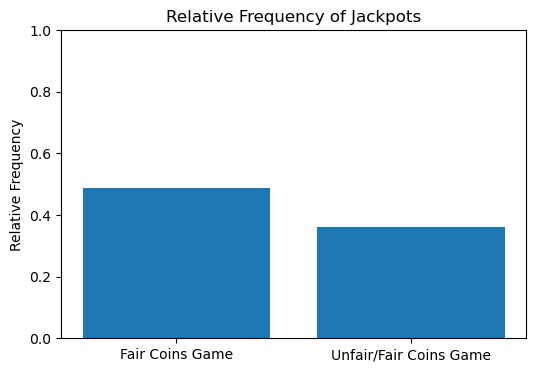

In [34]:
import matplotlib.pyplot as plt

labels = ['Fair Coins Game', 'Unfair/Fair Coins Game']

# Relative frequencies calculated earlier
frequencies = [relative_freq1, relative_freq2]

plt.figure(figsize=(6,4))
plt.bar(labels, frequencies)
plt.title('Relative Frequency of Jackpots')
plt.ylabel('Relative Frequency')
plt.ylim(0, 1)  # since relative frequency is between 0 and 1
plt.show()

## Scenario 2: A 6-sided Die (9)

Task 1. Create three dice, each with six sides having the faces 1 through 6.

- Three die objects created (1).

In [35]:
import numpy as np

# Faces from 1 to 6
faces = np.array([1, 2, 3, 4, 5, 6])

# Create three dice
die1 = Die(faces)
die2 = Die(faces)
die3 = Die(faces)

# Show each die's faces and weights
print("Die 1:")
print(die1.show())

print("\nDie 2:")
print(die2.show())

print("\nDie 3:")
print(die3.show())

Die 1:
      weight
face        
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0

Die 2:
      weight
face        
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0

Die 3:
      weight
face        
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0


Task 2. Convert one of the dice to an unfair one by weighting the face $6$ five times more than the other weights (i.e. it has weight of 5 and the others a weight of 1 each).

- Unfair die created with proper call to weight change method (1).

In [36]:
# Change the weight of face 6 to 5.0
die1.change_weight(6, 5.0)

# Show the updated die1
print("Updated Die 1 (Unfair Die):")
print(die1.show())

Updated Die 1 (Unfair Die):
      weight
face        
1        1.0
2        1.0
3        1.0
4        1.0
5        1.0
6        5.0


Task 3. Convert another of the dice to be unfair by weighting the face $1$ five times more than the others.

- Unfair die created with proper call to weight change method (1).

In [37]:
# Change the weight of face 1 to 5.0
die2.change_weight(1, 5.0)

# Show the updated die2
print("Updated Die 2 (Unfair Die):")
print(die2.show())

Updated Die 2 (Unfair Die):
      weight
face        
1        5.0
2        1.0
3        1.0
4        1.0
5        1.0
6        1.0


Task 4. Play a game of $10000$ rolls with $5$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [38]:

fair_die1 = Die(faces)
fair_die2 = Die(faces)
fair_die3 = Die(faces)
fair_die4 = Die(faces)
fair_die5 = Die(faces)

game3 = Game([fair_die1, fair_die2, fair_die3, fair_die4, fair_die5])

game3.play(10000)

print("Sample of 10,000 roll fair dice game:")
print(game3.show().head())

Sample of 10,000 roll fair dice game:
             0  1  2  3  4
roll_number               
0            3  4  3  4  2
1            1  5  5  5  2
2            4  5  5  3  6
3            4  2  4  6  4
4            1  6  5  3  4


Task 5. Play another game of $10000$ rolls, this time with $2$ unfair dice, one as defined in steps #2 and #3 respectively, and $3$ fair dice.

- Game class properly instantiated (1). 
- Play method called properly (1).

In [39]:
# Create 3 new fair dice
fair_die6 = Die(faces)
fair_die7 = Die(faces)
fair_die8 = Die(faces)

# Create a Game with 2 unfair dice and 3 fair dice
game4 = Game([die1, die2, fair_die6, fair_die7, fair_die8])

game4.play(10000)

print("Sample of 10,000-roll unfair/fair dice game:")
print(game4.show().head())

Sample of 10,000-roll unfair/fair dice game:
             0  1  2  3  4
roll_number               
0            6  1  1  5  5
1            2  1  5  6  6
2            6  1  6  5  6
3            4  1  5  6  5
4            5  4  1  1  5


Task 6. For each game, use an Analyzer object to determine the relative frequency of jackpots and show your results, comparing the two relative frequencies, in a simple bar chart.

- Jackpot methods called (1).
- Graph produced (1).

Relative frequency of jackpots (5 fair dice): 0.0008
Relative frequency of jackpots (2 unfair + 3 fair dice): 0.0002


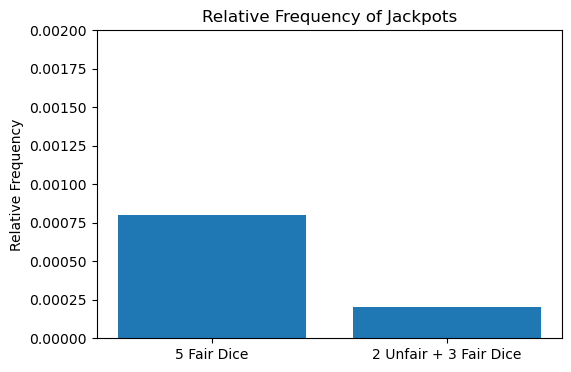

In [40]:

# Analyze the first game (5 fair dice)
analyzer3 = Analyzer(game3)
jackpots3 = analyzer3.jackpot()

# Analyze the second game (2 unfair dice + 3 fair dice)
analyzer4 = Analyzer(game4)
jackpots4 = analyzer4.jackpot()

total_rolls = 10000

relative_freq3 = jackpots3 / total_rolls
relative_freq4 = jackpots4 / total_rolls

print(f"Relative frequency of jackpots (5 fair dice): {relative_freq3:.4f}")
print(f"Relative frequency of jackpots (2 unfair + 3 fair dice): {relative_freq4:.4f}")

import matplotlib.pyplot as plt

labels = ['5 Fair Dice', '2 Unfair + 3 Fair Dice']
frequencies = [relative_freq3, relative_freq4]

plt.figure(figsize=(6,4))
plt.bar(labels, frequencies)
plt.title('Relative Frequency of Jackpots')
plt.ylabel('Relative Frequency')
plt.ylim(0, 0.002)
plt.show()

## Scenario 3: Letters of the Alphabet (7)

Task 1. Create a "die" of letters from $A$ to $Z$ with weights based on their frequency of usage as found in the data file `english_letters.txt`. Use the frequencies (i.e. raw counts) as weights.

- Die correctly instantiated with source file data (1).
- Weights properly applied using weight setting method (1).

In [41]:
faces = []
weights = []

with open('/home/wr9cn/Documents/MSDS/DS5100/Final-Project-DS5100/english_letters.txt', 'r') as file:
    for line in file:
        parts = line.strip().split()
        if len(parts) == 2:
            letter, freq = parts
            faces.append(letter.upper())  # Ensure uppercase
            weights.append(float(freq))   # Ensure numeric weight

faces_array = np.array(faces)
letter_die = Die(faces_array)

# Set the weights properly
for letter, weight in zip(faces, weights):
    letter_die.change_weight(letter, weight)

print("Letter Die (Faces and Weights):")
print(letter_die.show())

Letter Die (Faces and Weights):
           weight
face             
E     529117365.0
T     390965105.0
A     374061888.0
O     326627740.0
I     320410057.0
N     313720540.0
S     294300210.0
R     277000841.0
H     216768975.0
L     183996130.0
D     169330528.0
C     138416451.0
U     117295780.0
M     110504544.0
F      95422055.0
G      91258980.0
P      90376747.0
W      79843664.0
Y      75294515.0
B      70195826.0
V      46337161.0
K      35373464.0
J       9613410.0
X       8369915.0
Z       4975847.0
Q       4550166.0


Task 2. Play a game involving $4$ of these dice with $1000$ rolls.

- Game play method properly called (1).

In [51]:
game5 = Game([letter_die, letter_die, letter_die, letter_die])

game5.play(1000)

print("Sample of 1000-roll letter dice game:")
print(game5.show().head())

Sample of 1000-roll letter dice game:
             0  1  2  3
roll_number            
0            I  N  B  A
1            L  R  N  S
2            O  R  L  N
3            A  P  E  N
4            H  U  S  N


Task 3. Determine how many permutations in your results are actual English words, based on the vocabulary found in `scrabble_words.txt`.

- Use permutation method (1).
- Get count as difference between permutations and vocabulary (1).

In [52]:
analyzer5 = Analyzer(game5)

# Get all permutations rolled
permutations_df = analyzer5.permutation()

vocabulary = set()

with open('/home/wr9cn/Documents/MSDS/DS5100/Final-Project-DS5100/scrabble_words.txt', 'r') as file:
    for line in file:
        word = line.strip().upper()  # Make sure it's uppercase like faces
        if len(word) == 4:
            vocabulary.add(word)

matched_words = 0

for perm in permutations_df.index:
    word = ''.join(perm)
    if word in vocabulary:
        matched_words += permutations_df.loc[perm, 'count']

print(f"# of permutations that form real English words: {matched_words}")

# of permutations that form real English words: 52


Task 4. Repeat steps #2 and #3, this time with $5$ dice. How many actual words does this produce? Which produces more?

- Successfully repreats steps (1).
- Identifies parameter with most found words (1).

In [53]:
game6 = Game([letter_die, letter_die, letter_die, letter_die, letter_die])

game6.play(1000)

analyzer6 = Analyzer(game6)

permutations_df_5dice = analyzer6.permutation()

vocabulary5 = set()

with open('/home/wr9cn/Documents/MSDS/DS5100/Final-Project-DS5100/scrabble_words.txt', 'r') as file:
    for line in file:
        word = line.strip().upper()
        if len(word) == 5:
            vocabulary5.add(word)

matched_words_5dice = 0

for perm in permutations_df_5dice.index:
    word = ''.join(perm)
    if word in vocabulary5:
        matched_words_5dice += permutations_df_5dice.loc[perm, 'count']

print(f"# of permutations that form real English 5-letter words: {matched_words_5dice}")

# of permutations that form real English 5-letter words: 7
